In [2]:
%env SM_FRAMEWORK=tf.keras
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import cv2
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam
import random
seed =0
random.seed(seed) 
tf.random.set_seed(seed)
np.random.seed(seed)
import segmentation_models as sm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
def NormalizeData(data):
    Norm_data = []
    for i in range(data.shape[0]):
        norm = cv2.normalize(data[i],None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Norm_data.append(norm)
        
    return np.array(Norm_data)
        

In [4]:
def binbary_label(data):
    bin_data = []
    for i in range(data.shape[0]):
        img = data[i]
        bin_img = np.where(img>0,1,img)
        bin_data.append(bin_img)
#         chk = np.where(bin_img==1)
#         if len(chk)>5:
#             bin_data.append(bin_img)
    return np.array(bin_data)

In [5]:
def LoadData(p1,p2):
    data_ = nib.load(p1).get_fdata()
    data = np.transpose(data_,(2,0,1))
    label_ = nib.load(p2).get_fdata()
    label = np.transpose(label_,(2,0,1))
    
    unmask = NormalizeData(data)
    mask = binbary_label(label)
    return unmask,mask

In [6]:
def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext

def ProcessImage(path_file,mode='None',norm=True):
    dataset = []
    try:
        fns = sorted(glob.glob(path_file))
        for fn in fns:
            _, base, ext = split_filename(fn)
            img = nib.load(fn).get_data().astype(np.float32).squeeze()
            if img.ndim != 3:
                print(f'Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.')
                continue
            
            if mode =='mask':
                for i in range(img.shape[2]):
                    r_img =  img[:,:,i]
                    r_img = np.where(r_img>0,1,r_img)
                    dataset.append(r_img)
            
            else:
                for i in range(img.shape[2]):
                    I = Image.fromarray(img[:,:,i], mode='F')

                    oldmin = np.min(I)
                    oldmax = np.max(I)
                    oldrange = oldmax-oldmin

                    newmin = 0
                    newmax = 255
                    newrange = newmax-newmin
                    scale =(I-oldmin)/oldrange
                    if norm:
                        normal_img = ((newrange*scale) + newmin)/255.
                    else:
                        normal_img = ((newrange*scale) + newmin)

                    dataset.append(normal_img)


        return np.array(dataset)
    except Exception as e:
        print(e)
        return 1


In [7]:
def LoadData():
#     path_to_data = 'Task101_SCGM/imagesTr/*.nii*'
#     path_to_mask = 'Task101_SCGM/labelsTr/*.nii*'
    path_to_data = 'new_c/*.nii*'
    path_to_mask = 'new_s/*.nii*'
    unmask = ProcessImage(path_to_data,mode='unmask',norm=False)
    mask = ProcessImage(path_to_mask,mode='mask')
    return unmask,mask


In [ ]:
data,label = LoadData()

In [ ]:
Data = sorted(glob.glob('new_c/*'))
GT = sorted(glob.glob('new_s/*'))

data,label = LoadData(Data[2],GT[2])
print(data.shape)
print(label.shape)

In [8]:
import joblib as jlb
label,data=jlb.load("clean_mask_unmask")

In [9]:
unmask = np.expand_dims(data,axis=3)
mask = np.expand_dims(label,axis=3)

In [10]:
print(unmask.shape)
print(mask.shape)

(1736, 512, 512, 1)
(1736, 512, 512, 1)


In [11]:
def downsample(filters, size, shape, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer='he_normal'))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,padding='same',
                                    kernel_initializer='he_normal'))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.2))

    result.add(tf.keras.layers.ReLU())

    return result

In [12]:
OUTPUT_CHANNELS = 1
def buildUNet():
    inputs = tf.keras.layers.Input(shape=[512,512,1])
#     ye duplicate begir daram.mishe zangam bznm ya na?are 
    down_stack = [
        downsample(64, 3, (None, 512, 512,1), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 3, (None, 256, 256, 64)), # (bs, 128, 128, 128)
        downsample(128, 3, (None, 128, 128, 128)), # (bs, 64, 64, 128)
        downsample(256, 3, (None, 64, 64, 128)),
        downsample(256, 3, (None, 32, 32, 256)), # (bs, 16, 16, 512)
        downsample(512, 3, (None, 16, 16, 256)), # (bs, 8, 8, 512)
        downsample(512, 3, (None, 8, 8, 512)), # (bs, 4, 4, 512)
        downsample(512, 3, (None, 4, 4, 512)), # (bs, 2, 2, 512)
        downsample(512, 3, (None, 2, 2, 512)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 3, (None, 1, 1, 512), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 3, (None, 2, 2, 1024), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 3, (None, 4, 4, 1024), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 3, (None, 8, 8, 1024)), # (bs, 16, 16, 1024)
        upsample(256, 3, (None, 16, 16, 768)), # (bs, 32, 32, 512)
        upsample(256, 3, (None, 32, 32, 512)), # (bs, 64, 64, 256)
        upsample(128, 3, (None, 64, 64, 384)), # (bs, 128, 128, 128)
        upsample(128, 3, (None, 128, 128, 256)),
        upsample(64, 3, (None, 256, 256, 96)),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,strides=2,padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid') # (bs, 256, 256, 1)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
x_train,x_test,y_train,y_test = train_test_split(unmask,mask,test_size=0.2,random_state=0)

In [ ]:
# *****************************************************

In [15]:
model = buildUNet()

2023-03-31 22:02:36.226551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 22:02:37.111050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38159 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [17]:
#m_optimizer = tf.keras.optimizers.Adam(2e-4)
# model.compile(optimizer = m_optimizer, loss = loss_object, metrics = ['accuracy'])
# focal_loss = sm.losses.BinaryFocalLoss()
# model.compile(optimizer='adam',loss=focal_loss,metrics=['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 12  74368       ['sequential[0][0]']             
                                8)                                                            

In [ ]:
# ****with kfold

In [ ]:
import seaborn as sns
pred = model.predict(x_test)
pred = pred > 0.5
FP = len(np.where(pred - y_test == 1.)[0])
FN = len(np.where(pred - y_test == -1.)[0])
TP = len(np.where(pred + y_test == 2.)[0])
TN = len(np.where(pred + y_test == 0.)[0])
cmat = [[TP,FN],[FP,TN]]
print(cmat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
plt.xlabel('Predict')
plt.ylabel('real')
plt.show()
presicion = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 * (presicion*recall)/(presicion+recall)
Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
dice=(2*TP)/(2*TP+FP+FN)
iou=TP/(TP+FP+FN)

print("presicion: ",presicion)
print("recall: ",recall)
print("F1-Score: ",F1)
print("Pixel_accuracy: ",Pixel_accuracy)
print("dice: ",dice)
print("IoU: ",iou)

In [19]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
num_folds=5
x2 = np.concatenate((x_train,x_test))
y2 = np.concatenate((y_train,y_test))

all_history=[]
all_iou = []
all_precision=[]
all_recall=[]
all_F1=[]
all_dice=[]
all_paccuracy=[]

for train, test in KFold(num_folds).split(x2):
    xtrain,xtest=x2[train],x2[test]
    ytrain,ytest=y2[train],y2[test]
    histt = model.fit(xtrain,ytrain,epochs=650,shuffle=True,verbose=2,batch_size=16,validation_data=(xtest,ytest))
    all_history.append(histt)
    
#     y_pred = model.predict(xtest)
#     y_pred_th = y_pred > 0.5
#     intersection = np.logical_and(ytest,y_pred_th)
#     union = np.logical_or(ytest,y_pred_th)
#     iou_score = np.sum(intersection) / np.sum(union)
#     all_iou.append(iou_score)
    
    pred = model.predict(xtest)
    pred = pred > 0.5
    FP = len(np.where(pred - ytest == 1.)[0])
    FN = len(np.where(pred - ytest == -1.)[0])
    TP = len(np.where(pred + ytest == 2.)[0])
    TN = len(np.where(pred + ytest == 0.)[0])
    cmat = [[TP,FN],[FP,TN]]
    print(cmat)
    plt.figure(figsize=(6,6))
    sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
    plt.xlabel('Predict')
    plt.ylabel('real')
    plt.show()
    presicion = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 * (presicion*recall)/(presicion+recall)
    Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
    dice=(2*TP)/(2*TP+FP+FN)
    iou=TP/(TP+FP+FN)

    print("presicion: ",presicion)
    print("recall: ",recall)
    print("F1-Score: ",F1)
    print("Pixel_accuracy: ",Pixel_accuracy)
    print("dice: ",dice)
    print("IoU: ",iou)
    
    all_iou.append(iou)
    all_precision.append(presicion)
    all_recall.append(recall)
    all_F1.append(F1)
    all_dice.append(dice)
    all_paccuracy.append(Pixel_accuracy)
    
    print("\nresult:\t",model.evaluate(xtest,ytest.astype('float32')),'\n')

Epoch 1/650


2023-03-31 22:03:03.049436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-31 22:03:04.837305: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-03-31 22:03:05.906088: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-31 22:03:07.522274: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5555716a4b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-31 22:03:07.522312: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-03-31 22:03:07.528251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repro

87/87 - 25s - loss: 0.6715 - accuracy: 0.9486 - val_loss: 8.3987 - val_accuracy: 0.5229 - 25s/epoch - 285ms/step
Epoch 2/650
87/87 - 9s - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.2351 - val_accuracy: 0.9453 - 9s/epoch - 108ms/step
Epoch 3/650
87/87 - 9s - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0416 - val_accuracy: 0.9866 - 9s/epoch - 108ms/step
Epoch 4/650
87/87 - 9s - loss: 0.0146 - accuracy: 0.9952 - val_loss: 0.0178 - val_accuracy: 0.9939 - 9s/epoch - 108ms/step
Epoch 5/650
87/87 - 9s - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.0136 - val_accuracy: 0.9952 - 9s/epoch - 108ms/step
Epoch 6/650
87/87 - 9s - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.0472 - val_accuracy: 0.9859 - 9s/epoch - 109ms/step
Epoch 7/650
87/87 - 9s - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.0199 - val_accuracy: 0.9933 - 9s/epoch - 109ms/step
Epoch 8/650
87/87 - 10s - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.0330 - val_accuracy: 0.9902 - 10s/epoch - 109ms/step
Epoch 9/650
87/87 - 9s -

Epoch 67/650
87/87 - 9s - loss: 0.0031 - accuracy: 0.9986 - val_loss: 0.0057 - val_accuracy: 0.9979 - 9s/epoch - 109ms/step
Epoch 68/650
87/87 - 10s - loss: 0.0029 - accuracy: 0.9986 - val_loss: 0.0061 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 69/650
87/87 - 10s - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0057 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 70/650
87/87 - 10s - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0058 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 71/650
87/87 - 10s - loss: 0.0029 - accuracy: 0.9987 - val_loss: 0.0060 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 72/650
87/87 - 10s - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0061 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 73/650
87/87 - 10s - loss: 0.0028 - accuracy: 0.9987 - val_loss: 0.0071 - val_accuracy: 0.9974 - 10s/epoch - 109ms/step
Epoch 74/650
87/87 - 10s - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0067 - val_accuracy: 0.9978 - 10s/epoch - 109ms

Epoch 132/650
87/87 - 10s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0080 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 133/650
87/87 - 10s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0085 - val_accuracy: 0.9980 - 10s/epoch - 110ms/step
Epoch 134/650
87/87 - 10s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0087 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 135/650
87/87 - 10s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0090 - val_accuracy: 0.9980 - 10s/epoch - 110ms/step
Epoch 136/650
87/87 - 10s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0099 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 137/650
87/87 - 10s - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0092 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 138/650
87/87 - 10s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0093 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 139/650
87/87 - 10s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0094 - val_accuracy: 0.9979 - 10s/epo

Epoch 196/650
87/87 - 10s - loss: 7.9736e-04 - accuracy: 0.9997 - val_loss: 0.0156 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 197/650
87/87 - 10s - loss: 7.2617e-04 - accuracy: 0.9997 - val_loss: 0.0175 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 198/650
87/87 - 10s - loss: 7.3957e-04 - accuracy: 0.9997 - val_loss: 0.0166 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 199/650
87/87 - 10s - loss: 7.2183e-04 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 200/650
87/87 - 10s - loss: 6.9918e-04 - accuracy: 0.9997 - val_loss: 0.0165 - val_accuracy: 0.9979 - 10s/epoch - 109ms/step
Epoch 201/650
87/87 - 10s - loss: 6.0645e-04 - accuracy: 0.9998 - val_loss: 0.0167 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 202/650
87/87 - 10s - loss: 5.9649e-04 - accuracy: 0.9998 - val_loss: 0.0178 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 203/650
87/87 - 10s - loss: 6.1197e-04 - accuracy: 0.9998 - val_loss: 0.0187 

Epoch 259/650
87/87 - 10s - loss: 1.8046e-04 - accuracy: 0.9999 - val_loss: 0.0229 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 260/650
87/87 - 10s - loss: 1.4435e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 261/650
87/87 - 10s - loss: 1.3230e-04 - accuracy: 1.0000 - val_loss: 0.0241 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 262/650
87/87 - 10s - loss: 1.2875e-04 - accuracy: 1.0000 - val_loss: 0.0249 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 263/650
87/87 - 10s - loss: 1.3186e-04 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 264/650
87/87 - 10s - loss: 1.4880e-04 - accuracy: 1.0000 - val_loss: 0.0250 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 265/650
87/87 - 10s - loss: 2.0556e-04 - accuracy: 0.9999 - val_loss: 0.0257 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 266/650
87/87 - 10s - loss: 3.9083e-04 - accuracy: 0.9999 - val_loss: 0.0247 

Epoch 322/650
87/87 - 10s - loss: 6.0683e-04 - accuracy: 0.9998 - val_loss: 0.0222 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 323/650
87/87 - 10s - loss: 3.2418e-04 - accuracy: 0.9999 - val_loss: 0.0215 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 324/650
87/87 - 10s - loss: 1.5351e-04 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 325/650
87/87 - 10s - loss: 9.4263e-05 - accuracy: 1.0000 - val_loss: 0.0243 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 326/650
87/87 - 10s - loss: 6.3968e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9978 - 10s/epoch - 111ms/step
Epoch 327/650
87/87 - 10s - loss: 5.2135e-05 - accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 328/650
87/87 - 10s - loss: 4.4439e-05 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 329/650
87/87 - 10s - loss: 4.4811e-05 - accuracy: 1.0000 - val_loss: 0.0276 

Epoch 385/650
87/87 - 10s - loss: 4.4169e-05 - accuracy: 1.0000 - val_loss: 0.0308 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 386/650
87/87 - 10s - loss: 6.5737e-05 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 387/650
87/87 - 10s - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0227 - val_accuracy: 0.9973 - 10s/epoch - 110ms/step
Epoch 388/650
87/87 - 10s - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.0135 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 389/650
87/87 - 10s - loss: 4.9346e-04 - accuracy: 0.9998 - val_loss: 0.0142 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 390/650
87/87 - 10s - loss: 2.1959e-04 - accuracy: 0.9999 - val_loss: 0.0169 - val_accuracy: 0.9979 - 10s/epoch - 110ms/step
Epoch 391/650
87/87 - 10s - loss: 1.2635e-04 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 392/650
87/87 - 10s - loss: 9.0513e-05 - accuracy: 1.0000 - val_loss: 0.0218 - val_ac

Epoch 448/650
87/87 - 10s - loss: 3.0014e-04 - accuracy: 0.9999 - val_loss: 0.0292 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 449/650
87/87 - 10s - loss: 4.2129e-04 - accuracy: 0.9999 - val_loss: 0.0269 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 450/650
87/87 - 10s - loss: 3.5931e-04 - accuracy: 0.9999 - val_loss: 0.0258 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 451/650
87/87 - 10s - loss: 2.1025e-04 - accuracy: 0.9999 - val_loss: 0.0251 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 452/650
87/87 - 10s - loss: 1.1470e-04 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 453/650
87/87 - 10s - loss: 5.8510e-05 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 454/650
87/87 - 10s - loss: 3.4743e-05 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 455/650
87/87 - 10s - loss: 3.3669e-05 - accuracy: 1.0000 - val_loss: 0.0295 

Epoch 511/650
87/87 - 10s - loss: 1.1971e-05 - accuracy: 1.0000 - val_loss: 0.0299 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 512/650
87/87 - 10s - loss: 1.2078e-05 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 513/650
87/87 - 10s - loss: 1.1808e-05 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 514/650
87/87 - 10s - loss: 1.0333e-05 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 515/650
87/87 - 10s - loss: 9.5357e-06 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 516/650
87/87 - 10s - loss: 1.0351e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 517/650
87/87 - 10s - loss: 1.1131e-05 - accuracy: 1.0000 - val_loss: 0.0321 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 518/650
87/87 - 10s - loss: 1.4276e-05 - accuracy: 1.0000 - val_loss: 0.0322 

Epoch 574/650
87/87 - 10s - loss: 1.0166e-05 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 575/650
87/87 - 10s - loss: 8.9038e-06 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 576/650
87/87 - 10s - loss: 8.2083e-06 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 577/650
87/87 - 10s - loss: 8.0206e-06 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 578/650
87/87 - 10s - loss: 7.6369e-06 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 579/650
87/87 - 10s - loss: 8.1731e-06 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 580/650
87/87 - 10s - loss: 8.8414e-06 - accuracy: 1.0000 - val_loss: 0.0316 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 581/650
87/87 - 10s - loss: 8.3080e-06 - accuracy: 1.0000 - val_loss: 0.0318 

Epoch 637/650
87/87 - 10s - loss: 5.7247e-05 - accuracy: 1.0000 - val_loss: 0.0310 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 638/650
87/87 - 10s - loss: 8.8025e-05 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 639/650
87/87 - 10s - loss: 1.1097e-04 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 0.9978 - 10s/epoch - 111ms/step
Epoch 640/650
87/87 - 10s - loss: 1.4350e-04 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 641/650
87/87 - 9s - loss: 1.3935e-04 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9978 - 9s/epoch - 109ms/step
Epoch 642/650
87/87 - 10s - loss: 1.1034e-04 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9978 - 10s/epoch - 109ms/step
Epoch 643/650
87/87 - 10s - loss: 6.7281e-05 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9978 - 10s/epoch - 110ms/step
Epoch 644/650
87/87 - 10s - loss: 4.4364e-05 - accuracy: 1.0000 - val_loss: 0.0300 - 

Epoch 49/650
87/87 - 10s - loss: 6.2682e-05 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 50/650
87/87 - 10s - loss: 9.5957e-05 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9995 - 10s/epoch - 110ms/step
Epoch 51/650
87/87 - 10s - loss: 1.1356e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 52/650
87/87 - 10s - loss: 1.4077e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 53/650
87/87 - 10s - loss: 1.5650e-04 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9994 - 10s/epoch - 111ms/step
Epoch 54/650
87/87 - 10s - loss: 1.6581e-04 - accuracy: 0.9999 - val_loss: 0.0022 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 55/650
87/87 - 10s - loss: 1.4909e-04 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9995 - 10s/epoch - 111ms/step
Epoch 56/650
87/87 - 10s - loss: 1.2584e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_ac

Epoch 112/650
87/87 - 10s - loss: 9.5814e-05 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 113/650
87/87 - 10s - loss: 4.8406e-05 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 114/650
87/87 - 10s - loss: 3.0575e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 115/650
87/87 - 10s - loss: 1.8816e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 116/650
87/87 - 10s - loss: 1.3626e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 117/650
87/87 - 10s - loss: 1.0247e-05 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 118/650
87/87 - 10s - loss: 8.3585e-06 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 119/650
87/87 - 10s - loss: 8.2685e-06 - accuracy: 1.0000 - val_loss: 0.0028 

Epoch 175/650
87/87 - 10s - loss: 9.2601e-06 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 10s/epoch - 111ms/step
Epoch 176/650
87/87 - 10s - loss: 7.5021e-06 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 10s/epoch - 111ms/step
Epoch 177/650
87/87 - 10s - loss: 5.8874e-06 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9994 - 10s/epoch - 111ms/step
Epoch 178/650
87/87 - 10s - loss: 5.3711e-06 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 179/650
87/87 - 10s - loss: 6.7751e-06 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 180/650
87/87 - 10s - loss: 8.0509e-06 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 181/650
87/87 - 10s - loss: 1.2574e-05 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9994 - 10s/epoch - 110ms/step
Epoch 182/650
87/87 - 10s - loss: 1.4031e-05 - accuracy: 1.0000 - val_loss: 0.0037 

Epoch 238/650
87/87 - 10s - loss: 5.5708e-06 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 239/650
87/87 - 10s - loss: 7.2495e-06 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 240/650
87/87 - 10s - loss: 1.1396e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 241/650
87/87 - 10s - loss: 1.5322e-05 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 242/650
87/87 - 10s - loss: 3.8769e-05 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 243/650
87/87 - 10s - loss: 8.7633e-05 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9993 - 10s/epoch - 111ms/step
Epoch 244/650
87/87 - 10s - loss: 1.4972e-04 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 245/650
87/87 - 10s - loss: 1.5115e-04 - accuracy: 1.0000 - val_loss: 0.0043 

Epoch 301/650
87/87 - 10s - loss: 2.4577e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 302/650
87/87 - 10s - loss: 1.0256e-04 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 303/650
87/87 - 10s - loss: 2.6376e-04 - accuracy: 0.9999 - val_loss: 0.0051 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 304/650
87/87 - 10s - loss: 2.6055e-04 - accuracy: 0.9999 - val_loss: 0.0044 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 305/650
87/87 - 10s - loss: 1.5432e-04 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 306/650
87/87 - 10s - loss: 7.9262e-05 - accuracy: 1.0000 - val_loss: 0.0042 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 307/650
87/87 - 10s - loss: 3.6032e-05 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 308/650
87/87 - 10s - loss: 1.3312e-05 - accuracy: 1.0000 - val_loss: 0.0041 

Epoch 364/650
87/87 - 10s - loss: 1.5361e-05 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 365/650
87/87 - 10s - loss: 7.2626e-06 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 366/650
87/87 - 10s - loss: 7.2432e-06 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9992 - 10s/epoch - 113ms/step
Epoch 367/650
87/87 - 10s - loss: 5.0903e-06 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9992 - 10s/epoch - 113ms/step
Epoch 368/650
87/87 - 10s - loss: 3.1882e-06 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 369/650
87/87 - 10s - loss: 2.1053e-06 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 370/650
87/87 - 10s - loss: 1.6083e-06 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9992 - 10s/epoch - 112ms/step
Epoch 371/650
87/87 - 10s - loss: 1.5260e-06 - accuracy: 1.0000 - val_loss: 0.0049 

Epoch 427/650
87/87 - 10s - loss: 1.8038e-06 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 428/650
87/87 - 10s - loss: 1.6944e-06 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 429/650
87/87 - 10s - loss: 1.5218e-06 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 430/650
87/87 - 10s - loss: 1.6382e-06 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 431/650
87/87 - 10s - loss: 1.3495e-06 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 432/650
87/87 - 10s - loss: 1.2217e-06 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 433/650
87/87 - 10s - loss: 1.2714e-06 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 0.9992 - 10s/epoch - 111ms/step
Epoch 434/650
87/87 - 10s - loss: 1.2406e-06 - accuracy: 1.0000 - val_loss: 0.0053 

Epoch 490/650
87/87 - 10s - loss: 1.5800e-06 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 491/650
87/87 - 10s - loss: 1.2714e-06 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 0.9992 - 10s/epoch - 109ms/step
Epoch 492/650
87/87 - 10s - loss: 1.0588e-06 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 493/650
87/87 - 10s - loss: 9.7301e-07 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 494/650
87/87 - 10s - loss: 8.6720e-07 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 495/650
87/87 - 10s - loss: 1.0228e-06 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9992 - 10s/epoch - 109ms/step
Epoch 496/650
87/87 - 10s - loss: 1.0728e-06 - accuracy: 1.0000 - val_loss: 0.0058 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 497/650
87/87 - 10s - loss: 1.0461e-06 - accuracy: 1.0000 - val_loss: 0.0059 

Epoch 553/650
87/87 - 10s - loss: 1.3571e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 554/650
87/87 - 10s - loss: 7.4215e-06 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9992 - 10s/epoch - 110ms/step
Epoch 555/650
87/87 - 10s - loss: 6.4113e-06 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 556/650
87/87 - 10s - loss: 8.0751e-06 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 557/650
87/87 - 10s - loss: 1.7672e-05 - accuracy: 1.0000 - val_loss: 0.0068 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 558/650
87/87 - 10s - loss: 2.7243e-05 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 559/650
87/87 - 10s - loss: 4.8150e-05 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - 10s/epoch - 111ms/step
Epoch 560/650
87/87 - 10s - loss: 5.9153e-05 - accuracy: 1.0000 - val_loss: 0.0064 

Epoch 616/650
87/87 - 10s - loss: 9.0745e-07 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 617/650
87/87 - 10s - loss: 6.0968e-07 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 618/650
87/87 - 10s - loss: 6.2076e-07 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 619/650
87/87 - 10s - loss: 6.2104e-07 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 620/650
87/87 - 10s - loss: 5.3705e-07 - accuracy: 1.0000 - val_loss: 0.0064 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 621/650
87/87 - 10s - loss: 4.6264e-07 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 622/650
87/87 - 10s - loss: 4.6721e-07 - accuracy: 1.0000 - val_loss: 0.0065 - val_accuracy: 0.9991 - 10s/epoch - 110ms/step
Epoch 623/650
87/87 - 10s - loss: 4.6539e-07 - accuracy: 1.0000 - val_loss: 0.0065 

Epoch 27/650
87/87 - 10s - loss: 4.6974e-05 - accuracy: 1.0000 - val_loss: 2.1689e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 28/650
87/87 - 10s - loss: 4.7575e-05 - accuracy: 1.0000 - val_loss: 2.5731e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 29/650
87/87 - 10s - loss: 5.1737e-05 - accuracy: 1.0000 - val_loss: 2.6477e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 30/650
87/87 - 10s - loss: 5.2508e-05 - accuracy: 1.0000 - val_loss: 2.4329e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 31/650
87/87 - 10s - loss: 5.1803e-05 - accuracy: 1.0000 - val_loss: 2.4946e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 32/650
87/87 - 10s - loss: 4.7757e-05 - accuracy: 1.0000 - val_loss: 2.6035e-04 - val_accuracy: 0.9999 - 10s/epoch - 111ms/step
Epoch 33/650
87/87 - 10s - loss: 5.7666e-05 - accuracy: 1.0000 - val_loss: 3.3008e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 34/650
87/87 - 10s - loss: 5.8973e-05 - accuracy: 1.0000

Epoch 89/650
87/87 - 10s - loss: 1.1914e-05 - accuracy: 1.0000 - val_loss: 3.6625e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 90/650
87/87 - 10s - loss: 6.3800e-06 - accuracy: 1.0000 - val_loss: 3.5664e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 91/650
87/87 - 10s - loss: 3.6152e-06 - accuracy: 1.0000 - val_loss: 3.5277e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 92/650
87/87 - 10s - loss: 3.0450e-06 - accuracy: 1.0000 - val_loss: 3.5370e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 93/650
87/87 - 10s - loss: 2.3537e-06 - accuracy: 1.0000 - val_loss: 3.5145e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 94/650
87/87 - 10s - loss: 1.9213e-06 - accuracy: 1.0000 - val_loss: 3.5038e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 95/650
87/87 - 10s - loss: 1.5160e-06 - accuracy: 1.0000 - val_loss: 3.5082e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 96/650
87/87 - 10s - loss: 1.3667e-06 - accuracy: 1.0000

Epoch 150/650
87/87 - 10s - loss: 1.5475e-06 - accuracy: 1.0000 - val_loss: 4.8256e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 151/650
87/87 - 10s - loss: 1.0758e-06 - accuracy: 1.0000 - val_loss: 4.8085e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 152/650
87/87 - 10s - loss: 1.0033e-06 - accuracy: 1.0000 - val_loss: 4.8072e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 153/650
87/87 - 10s - loss: 8.2880e-07 - accuracy: 1.0000 - val_loss: 4.8334e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 154/650
87/87 - 10s - loss: 8.8453e-07 - accuracy: 1.0000 - val_loss: 4.8554e-04 - val_accuracy: 0.9999 - 10s/epoch - 110ms/step
Epoch 155/650
87/87 - 9s - loss: 9.1095e-07 - accuracy: 1.0000 - val_loss: 4.8553e-04 - val_accuracy: 0.9999 - 9s/epoch - 109ms/step
Epoch 156/650
87/87 - 10s - loss: 8.9475e-07 - accuracy: 1.0000 - val_loss: 4.8341e-04 - val_accuracy: 0.9999 - 10s/epoch - 109ms/step
Epoch 157/650
87/87 - 10s - loss: 7.1884e-07 - accuracy: 

Epoch 211/650
87/87 - 10s - loss: 1.9670e-06 - accuracy: 1.0000 - val_loss: 6.2775e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 212/650
87/87 - 10s - loss: 1.3657e-06 - accuracy: 1.0000 - val_loss: 6.3809e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 213/650
87/87 - 10s - loss: 1.7739e-06 - accuracy: 1.0000 - val_loss: 6.3037e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 214/650
87/87 - 10s - loss: 1.6144e-06 - accuracy: 1.0000 - val_loss: 6.2712e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 215/650
87/87 - 10s - loss: 1.4234e-06 - accuracy: 1.0000 - val_loss: 6.3476e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 216/650
87/87 - 10s - loss: 1.2800e-06 - accuracy: 1.0000 - val_loss: 6.4566e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 217/650
87/87 - 10s - loss: 1.6303e-06 - accuracy: 1.0000 - val_loss: 6.3364e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 218/650
87/87 - 10s - loss: 9.8735e-07 - accuracy

Epoch 272/650
87/87 - 10s - loss: 3.7360e-06 - accuracy: 1.0000 - val_loss: 8.2233e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 273/650
87/87 - 10s - loss: 2.3189e-06 - accuracy: 1.0000 - val_loss: 7.7292e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 274/650
87/87 - 10s - loss: 1.6956e-06 - accuracy: 1.0000 - val_loss: 7.7817e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 275/650
87/87 - 10s - loss: 1.5671e-06 - accuracy: 1.0000 - val_loss: 7.8209e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 276/650
87/87 - 10s - loss: 1.1009e-06 - accuracy: 1.0000 - val_loss: 7.7454e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 277/650
87/87 - 10s - loss: 1.1275e-06 - accuracy: 1.0000 - val_loss: 7.7580e-04 - val_accuracy: 0.9998 - 10s/epoch - 111ms/step
Epoch 278/650
87/87 - 10s - loss: 7.7026e-07 - accuracy: 1.0000 - val_loss: 7.8090e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 279/650
87/87 - 10s - loss: 7.1921e-07 - accuracy

Epoch 334/650
87/87 - 9s - loss: 1.0103e-05 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 335/650
87/87 - 10s - loss: 4.9881e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 336/650
87/87 - 9s - loss: 4.2515e-06 - accuracy: 1.0000 - val_loss: 9.9442e-04 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 337/650
87/87 - 9s - loss: 2.6663e-06 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 338/650
87/87 - 9s - loss: 1.1829e-06 - accuracy: 1.0000 - val_loss: 9.6810e-04 - val_accuracy: 0.9998 - 9s/epoch - 109ms/step
Epoch 339/650
87/87 - 10s - loss: 8.9190e-07 - accuracy: 1.0000 - val_loss: 9.6488e-04 - val_accuracy: 0.9998 - 10s/epoch - 109ms/step
Epoch 340/650
87/87 - 10s - loss: 7.5223e-07 - accuracy: 1.0000 - val_loss: 9.6634e-04 - val_accuracy: 0.9998 - 10s/epoch - 110ms/step
Epoch 341/650
87/87 - 9s - loss: 8.6598e-07 - accuracy: 1.0000 - val_loss: 

Epoch 397/650
87/87 - 9s - loss: 2.0053e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 398/650
87/87 - 9s - loss: 1.2445e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 399/650
87/87 - 9s - loss: 7.6419e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 400/650
87/87 - 9s - loss: 7.8290e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 401/650
87/87 - 9s - loss: 7.0890e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 402/650
87/87 - 10s - loss: 6.4154e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 403/650
87/87 - 10s - loss: 6.1406e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 404/650
87/87 - 10s - loss: 6.2362e-07 - accuracy: 1.0000 - val_loss: 0.0011 - val_accu

Epoch 460/650
87/87 - 10s - loss: 2.4401e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 461/650
87/87 - 10s - loss: 7.0365e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 0.9996 - 10s/epoch - 109ms/step
Epoch 462/650
87/87 - 10s - loss: 1.4035e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 0.9996 - 10s/epoch - 110ms/step
Epoch 463/650
87/87 - 10s - loss: 1.4476e-04 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 464/650
87/87 - 10s - loss: 6.9138e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 465/650
87/87 - 9s - loss: 3.5976e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 466/650
87/87 - 9s - loss: 1.4965e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 467/650
87/87 - 10s - loss: 7.1405e-06 - accuracy: 1.0000 - val_loss: 0.0013 - va

Epoch 523/650
87/87 - 10s - loss: 4.0986e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 0.9996 - 10s/epoch - 109ms/step
Epoch 524/650
87/87 - 10s - loss: 9.5022e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 525/650
87/87 - 10s - loss: 4.3973e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 526/650
87/87 - 10s - loss: 2.7005e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 110ms/step
Epoch 527/650
87/87 - 10s - loss: 2.0891e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 528/650
87/87 - 10s - loss: 1.7493e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 10s/epoch - 109ms/step
Epoch 529/650
87/87 - 9s - loss: 1.4335e-06 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9997 - 9s/epoch - 109ms/step
Epoch 530/650
87/87 - 10s - loss: 1.2958e-06 - accuracy: 1.0000 - val_loss: 0.0014 - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

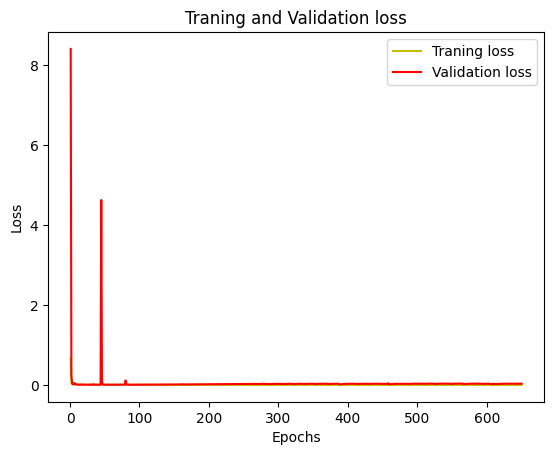

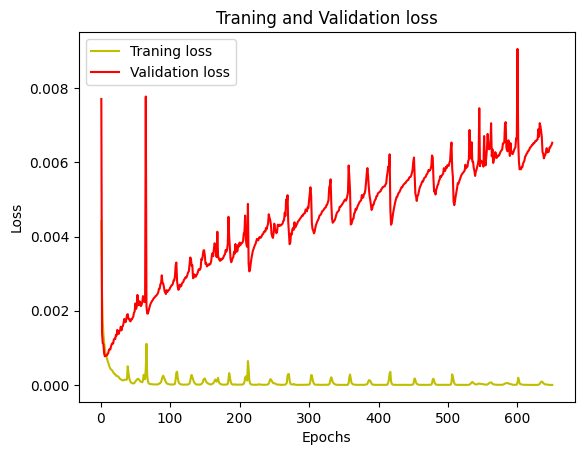

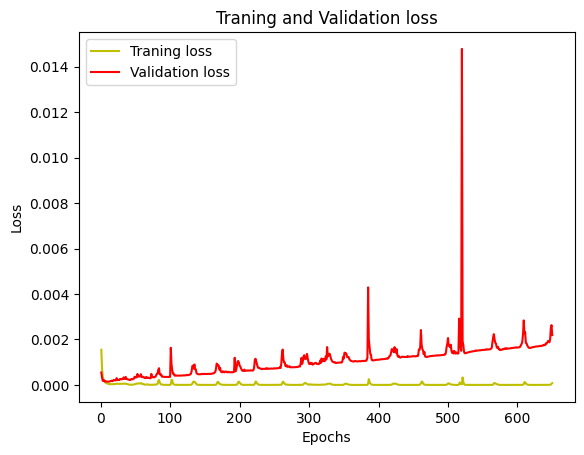

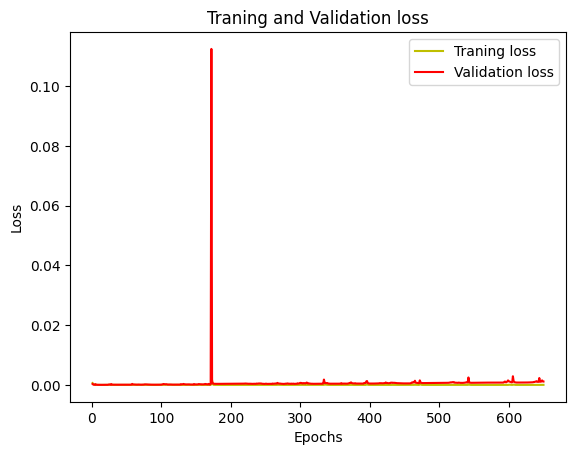

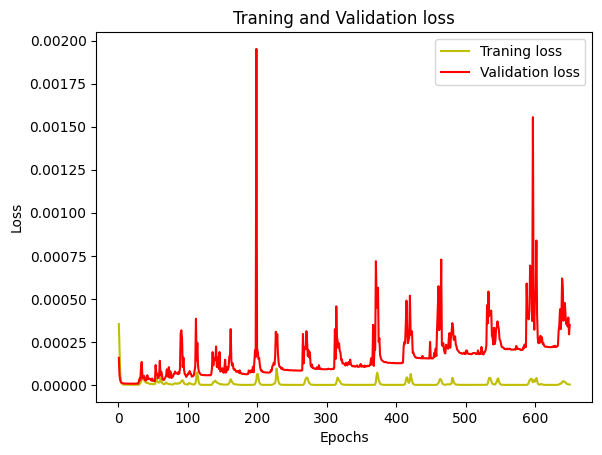

In [21]:
for i in range (len(all_history)) :
     Plot_ACC_LOSS(all_history[i])

In [22]:
model.save("seg-2class-650e.hdf5")

In [23]:
all_iou

[0.9288389876074735,
 0.9706021834284356,
 0.9866539766063674,
 0.991828956220866,
 0.9968327328652202]

In [24]:
np.mean(np.array(all_iou))


0.9749513673456726

In [ ]:
# without kfold

In [ ]:
def showsingleimage(img):
    print("min:",np.min(img))
    print("max:",np.max(img))
    plt.imshow(img)
    plt.show()

In [ ]:
history = model.fit(x_train,y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=50,
                    validation_data=(x_test,y_test),
                    #class_weight=class_weights,
                    shuffle=False)

In [ ]:
Plot_ACC_LOSS(history)
# model.save("seg-5class.hdf5")

In [ ]:

#n_class=1
_,acc = model.evaluate(x_test,y_test)
print("Accuracy is :",(acc * 100.0),"%")


# model.load_weights("seg-5class.hdf5")

y_pred = model.predict(x_test)

y_pred_th = y_pred > 0.5
intersection = np.logical_and(y_test,y_pred_th)
union = np.logical_or(y_test,y_pred_th)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:",iou_score) 


11/11 [==============================] - 1s 64ms/step
[[2668691, 4247], [4174, 88549000]]


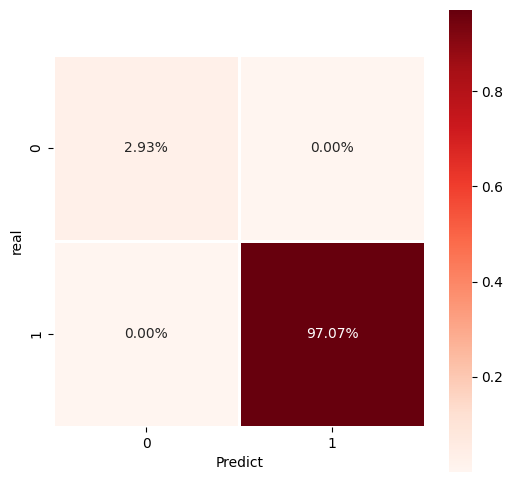

presicion:  0.9984383797909734
recall:  0.9984111116681345
F1-Score:  0.998424745543373
Pixel_accuracy:  0.9999076909032362
dice:  0.998424745543373
IoU:  0.9968544461344911


In [27]:
import seaborn as sns
pred = model.predict(x_test)
pred = pred > 0.5
FP = len(np.where(pred - y_test == 1.)[0])
FN = len(np.where(pred - y_test == -1.)[0])
TP = len(np.where(pred + y_test == 2.)[0])
TN = len(np.where(pred + y_test == 0.)[0])
cmat = [[TP,FN],[FP,TN]]
print(cmat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
plt.xlabel('Predict')
plt.ylabel('real')
plt.show()
presicion = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 * (presicion*recall)/(presicion+recall)
Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
dice=(2*TP)/(2*TP+FP+FN)
iou=TP/(TP+FP+FN)

print("presicion: ",presicion)
print("recall: ",recall)
print("F1-Score: ",F1)
print("Pixel_accuracy: ",Pixel_accuracy)
print("dice: ",dice)
print("IoU: ",iou)

1/1 [==============================] - 0s 307ms/step


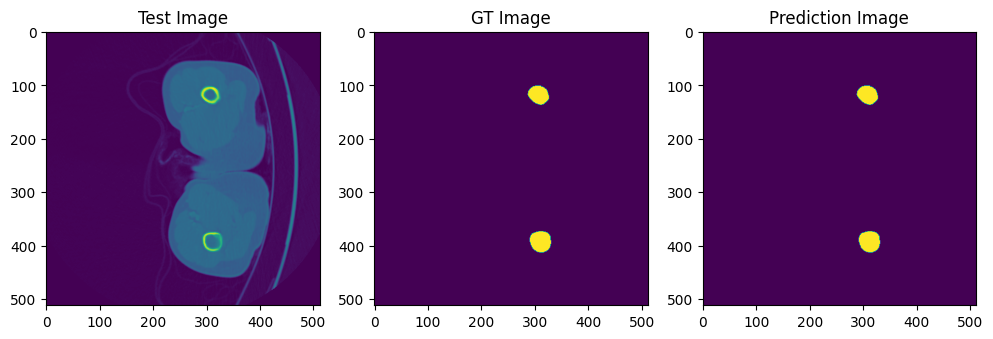

In [25]:
n_test_img = np.random.randint(0,len(x_test)-1)
test_img = x_test[n_test_img]
GT = y_test[n_test_img]
test_img_input = np.expand_dims(test_img,axis=0)
prediction = (model.predict(test_img_input)[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('GT Image')
plt.imshow(GT)
plt.subplot(133)
plt.title('Prediction Image')
plt.imshow(prediction)
plt.show()

In [ ]:
for i in range (len(all_history)) :
    score()